In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split

from src.preprocess import transform_to_data_loader
from src.train import train_model

from torchinfo import summary
from torchaudio.transforms import MFCC

### Silence detection

In [8]:
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
silence = np.load("silence.npy")
sound = np.load("augmented_data.npy")

sound_indices = random.sample(range(1, sound.shape[0]), silence.shape[0])
sound = sound[sound_indices]


In [10]:
X_silence = np.concatenate((silence, sound), 0)
y_silence = np.concatenate((np.ones(silence.shape[0]), np.zeros(sound.shape[0])), 0)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_silence, y_silence, test_size=0.2, random_state=42
)

X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)

In [13]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_test, y_test, device=device)

In [11]:
for a, b in train_dl:
    break

In [20]:
class BiLSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, dropout, fc_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True, 
            bidirectional=True, 
            num_layers=num_layers,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(2*hidden_size, fc_size)  # *2 because of bidirectional
        self.fc2 = nn.Linear(fc_size, 1)
        self.bc1 = nn.BatchNorm1d(2*hidden_size)
        self.bc2 = nn.BatchNorm1d(fc_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.lstm(x)[0][:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [21]:
input_size = 16000
hidden_size = 32

model = bin_BiLSTM(input_size, hidden_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.0001)

In [22]:
summary(model, (1, 1, 16000))

Layer (type:depth-idx)                   Output Shape              Param #
bin_BiLSTM                               [1, 1]                    --
├─LSTM: 1-1                              [1, 1, 64]                4,104,704
├─Dropout: 1-2                           [1, 64]                   --
├─BatchNorm1d: 1-3                       [1, 64]                   128
├─Linear: 1-4                            [1, 64]                   4,160
├─Dropout: 1-5                           [1, 64]                   --
├─ReLU: 1-6                              [1, 64]                   --
├─BatchNorm1d: 1-7                       [1, 64]                   128
├─Linear: 1-8                            [1, 1]                    65
├─Sigmoid: 1-9                           [1, 1]                    --
Total params: 4,109,185
Trainable params: 4,109,185
Non-trainable params: 0
Total mult-adds (M): 4.11
Input size (MB): 0.06
Forward/backward pass size (MB): 0.00
Params size (MB): 16.44
Estimated Total Size (MB): 

In [ ]:
train_losses, val_losses = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    early_stopping=True,
    device=device
)

In [ ]:
train_losses, val_losses = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    early_stopping=True,
    device=device
)

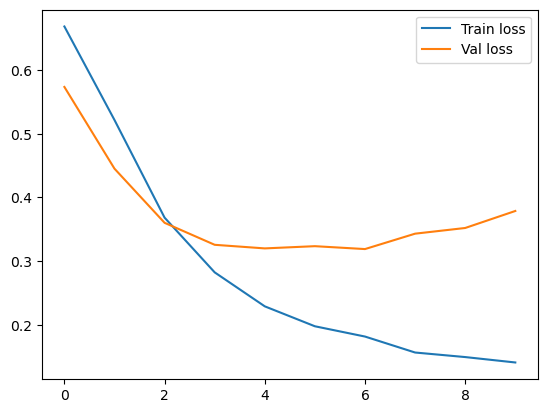

In [53]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Train loss", "Val loss"])
plt.show()

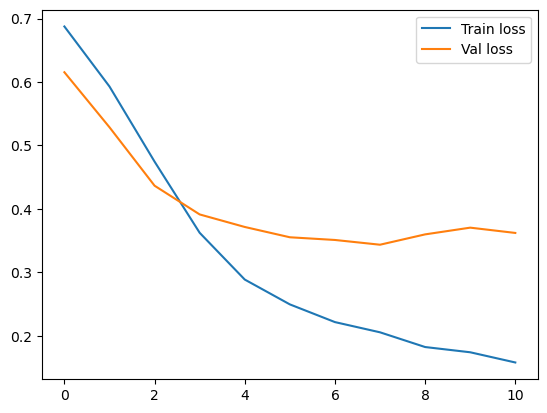

In [19]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Train loss", "Val loss"])
plt.show()